In [3]:
import numpy as np
from scipy.ndimage.filters import convolve
from scipy.signal import correlate
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
# Constants

w = 255
b = 0

In [11]:

def visualize_conv(input, filter):
    output = correlate(input, filter, mode='same')
    ratio = input.shape[1] / filter.shape[1]
    # max_value = np.sum(abs(filter)) * w
     
    fig, axs = plt.subplots(1, 3, gridspec_kw = dict(width_ratios = [ratio,1,ratio]))
    axs[0].matshow(input, cmap=plt.cm.gray)
    axs[0].set_title('Input')
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    
    axs[1].matshow(filter, cmap=plt.cm.gray)
    axs[1].set_title('Filter')
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    
    axs[2].matshow(output, cmap=plt.cm.gray)
    axs[2].set_title('Output')
    axs[2].set_xticks([])
    axs[2].set_yticks([])
    
    return output



In [6]:
# Basic input patterns

v_stripes = np.array([[b, w, b, w], 
                  [b, w, b, w],
                  [b, w, b, w],
                  [b, w, b, w]])

h_stripes = np.array([[b, b, b, b], 
                  [w, w, w, w],
                  [b, b, b, b],
                  [w, w, w, w]])

checker = np.array([[b, w, b, w],
                    [w, b, w, b],
                    [b, w, b, w],
                    [w, b, w, b]])

def get_rand_input(size=4):
    return np.random.choice([b,w],(size, size))

# basic filters 

v_edge_22 = np.array([[1, -1],
                      [1, -1]])

h_edge_22 = np.array([[1, 1],
                      [-1, -1]])

diag_22 = np.array([[1, -1],
                    [-1, 1]])

diff_21 = np.array([[1],
                   [-1]])

same_21 = np.array([[1],
                    [1]])

v_edge_33 = np.array([[-1, 2, -1],
                      [-1, 2, -1],
                      [-1, 2, -1]])

h_edge_33 = np.array([[-1, -1, -1],
                      [2, 2, 2],
                      [-1, -1, -1]])


def get_rand_filter(dims=(2,2)):
    return np.random.choice([1,-1], dims)

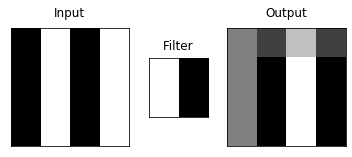

In [12]:
output = visualize_conv(v_stripes, v_edge_22)

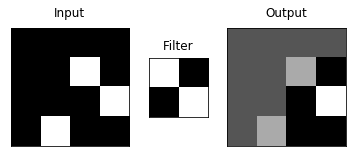

In [13]:
output = visualize_conv(get_rand_input(), diag_22)

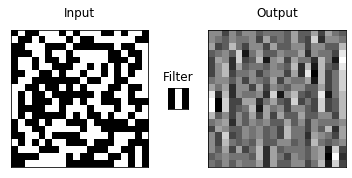

In [14]:
output = visualize_conv(get_rand_input(20), v_edge_33)

Output: [[ 255 -255    0  255]
 [   0  255    0 -255]
 [   0 -255  255 -255]
 [   0    0 -255  255]]


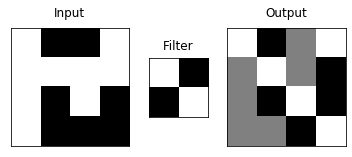

In [15]:
output = visualize_conv(get_rand_input(4), diag_22)

print(f"Output: {output}")